In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

C:\Users\riyab\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\riyab\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data Requirements
Dataset Features:

* 1,000 customers with realistic business relationships
* 4 input features with appropriate ranges and correlations
* 2 target variables for both regression and classification demos

Realistic Business Logic:

* Ad Spend ($500-$5,000): Drives both traffic and sales
* Website Traffic (1,000-20,000): Correlated with ad spend
* Email Campaigns (0-50): Poisson distribution (realistic for marketing)
* Social Media Reach (5,000-100,000): Correlated with ad spend
* Monthly Sales: Realistic ROI relationships ($2.50 per $1 ad spend)
* High Value Customer: Logistic relationship with sales (>$25K threshold)

# Data Stimulation code:

In [26]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate 1000 customers
n_customers = 1000

# Generate features with realistic correlations
# Ad spend: $500-$5000 per month
ad_spend = np.random.normal(2000, 800, n_customers)
ad_spend = np.clip(ad_spend, 500, 5000)

# Website traffic: 1000-20000 monthly visits (correlated with ad spend)
website_traffic = ad_spend * 3 + np.random.normal(0, 1000, n_customers)
website_traffic = np.clip(website_traffic, 1000, 20000)

# Email campaigns: 0-50 campaigns per month
email_campaigns = np.random.poisson(10, n_customers)
email_campaigns = np.clip(email_campaigns, 0, 50)

# Social media reach: 5000-100000 impressions (some correlation with ad spend)
social_media_reach = ad_spend * 15 + np.random.normal(0, 10000, n_customers)
social_media_reach = np.clip(social_media_reach, 5000, 100000)

# Generate monthly sales (regression target)
# More realistic business relationship
monthly_sales = (
    ad_spend * 2.5 +  # $2.5 revenue per $1 ad spend
    website_traffic * 0.8 +  # $0.8 per website visit
    email_campaigns * 150 +  # $150 per email campaign
    social_media_reach * 0.02 +  # $0.02 per social media impression
    np.random.normal(0, 2000, n_customers)  # Random noise
)
monthly_sales = np.clip(monthly_sales, 1000, 50000)

# Generate high_value_customer (classification target)
# Customers with sales > $25000 are high value
# Add some randomness to make it more realistic
sales_threshold = 25000
high_value_prob = 1 / (1 + np.exp(-(monthly_sales - sales_threshold) / 5000))
high_value_customer = np.random.binomial(1, high_value_prob)

# Create DataFrame
df = pd.DataFrame({
    'ad_spend': ad_spend.round(2),
    'website_traffic': website_traffic.round(0).astype(int),
    'email_campaigns': email_campaigns,
    'social_media_reach': social_media_reach.round(0).astype(int),
    'monthly_sales': monthly_sales.round(2),
    'high_value_customer': high_value_customer
})

In [16]:
df.to_csv('ecommerce_marketing_data.csv', index=False)
print(f"\nDataset saved as 'ecommerce_marketing_data.csv'")


Dataset saved as 'ecommerce_marketing_data.csv'


In [4]:
df.head()

,ad_spend,website_traffic,email_campaigns,social_media_reach,monthly_sales,high_value_customer
0,2397.37,8591,9,26044,16224.78,0
1,1889.39,6593,8,22012,11228.20,0
2,2518.15,7614,10,39666,14742.75,0
3,3218.42,9008,4,51249,20092.86,0
4,1812.68,6136,3,15298,10155.53,0


In [6]:
# Display basic info
print("E-commerce Marketing Dataset")
print("=" * 40)
print(f"Dataset shape: {df.shape}")
print(f"High-value customers: {df['high_value_customer'].sum()} ({df['high_value_customer'].mean()*100:.1f}%)")
print()

E-commerce Marketing Dataset
Dataset shape: (1000, 6)
High-value customers: 78 (7.8%)



In [7]:
# Display first few rows
print("First 10 rows:")
print(df.head(10))
print()

First 10 rows:
   ad_spend  website_traffic  email_campaigns  social_media_reach  \
0   2397.37             8591                9               26044   
1   1889.39             6593                8               22012   
2   2518.15             7614               10               39666   
3   3218.42             9008                4               51249   
4   1812.68             6136                3               15298   
5   1812.69             5832                9               37730   
6   3263.37            10685                7               54671   
7   2613.95             8477                9               32162   
8   1624.42             5923                8                8990   
9   2434.05             6767                7               35062   

   monthly_sales  high_value_customer  
0       16224.78                    0  
1       11228.20                    0  
2       14742.75                    0  
3       20092.86                    0  
4       10155.53         

In [8]:
# Display summary statistics
print("Summary Statistics:")
print(df.describe())
print()

Summary Statistics:
          ad_spend  website_traffic  email_campaigns  social_media_reach  \
count  1000.000000      1000.000000      1000.000000         1000.000000   
mean   2021.625840      6141.296000         9.968000        30249.904000   
std     768.732174      2463.998061         3.164647        14606.719083   
min     500.000000      1000.000000         2.000000         5000.000000   
25%    1481.927500      4473.000000         8.000000        19967.500000   
50%    2020.240000      6073.500000        10.000000        30476.000000   
75%    2518.355000      7693.750000        12.000000        40200.750000   
max    5000.000000     16750.000000        21.000000        77805.000000   

       monthly_sales  high_value_customer  
count    1000.000000          1000.000000  
mean    11995.582270             0.078000  
std      4534.265286             0.268306  
min      1000.000000             0.000000  
25%      8659.982500             0.000000  
50%     11797.915000           

In [9]:
# Check correlations
print("Feature Correlations with Monthly Sales:")
features = ['ad_spend', 'website_traffic', 'email_campaigns', 'social_media_reach']
for feature in features:
    corr = df[feature].corr(df['monthly_sales'])
    print(f"{feature}: {corr:.3f}")
print()

Feature Correlations with Monthly Sales:
ad_spend: 0.872
website_traffic: 0.872
email_campaigns: 0.071
social_media_reach: 0.673



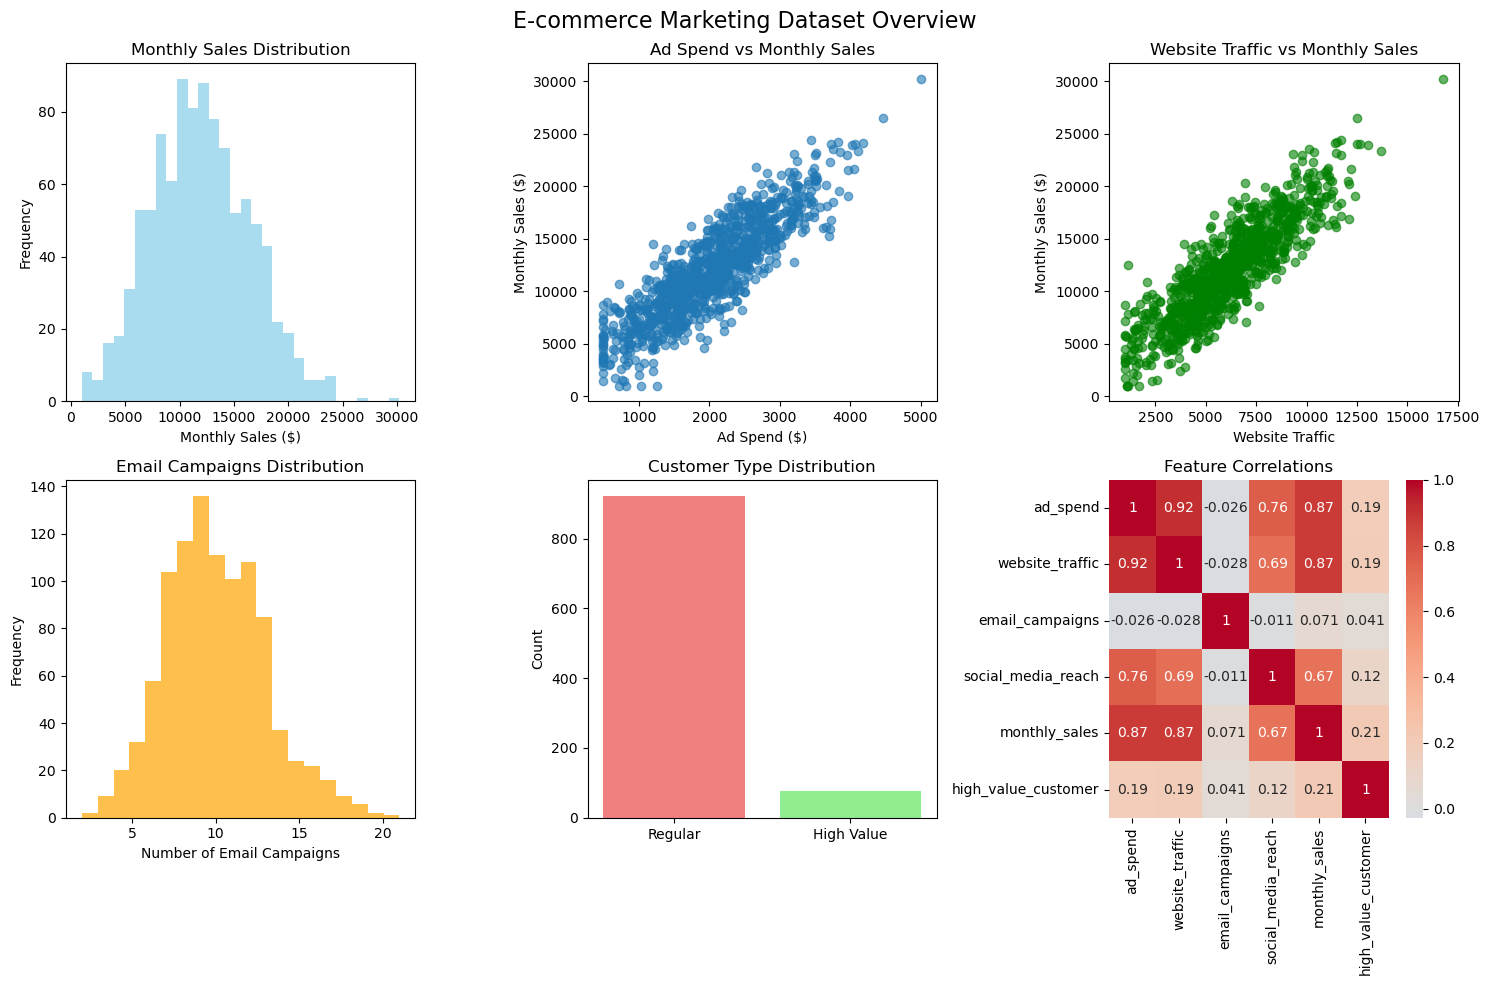

In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('E-commerce Marketing Dataset Overview', fontsize=16)

# 1. Monthly Sales Distribution
axes[0, 0].hist(df['monthly_sales'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Monthly Sales Distribution')
axes[0, 0].set_xlabel('Monthly Sales ($)')
axes[0, 0].set_ylabel('Frequency')

# 2. Ad Spend vs Monthly Sales
axes[0, 1].scatter(df['ad_spend'], df['monthly_sales'], alpha=0.6)
axes[0, 1].set_title('Ad Spend vs Monthly Sales')
axes[0, 1].set_xlabel('Ad Spend ($)')
axes[0, 1].set_ylabel('Monthly Sales ($)')

# 3. Website Traffic vs Monthly Sales
axes[0, 2].scatter(df['website_traffic'], df['monthly_sales'], alpha=0.6, color='green')
axes[0, 2].set_title('Website Traffic vs Monthly Sales')
axes[0, 2].set_xlabel('Website Traffic')
axes[0, 2].set_ylabel('Monthly Sales ($)')

# 4. Email Campaigns Distribution
axes[1, 0].hist(df['email_campaigns'], bins=20, alpha=0.7, color='orange')
axes[1, 0].set_title('Email Campaigns Distribution')
axes[1, 0].set_xlabel('Number of Email Campaigns')
axes[1, 0].set_ylabel('Frequency')

# 5. High Value Customer Distribution
high_value_counts = df['high_value_customer'].value_counts()
axes[1, 1].bar(['Regular', 'High Value'], high_value_counts.values, color=['lightcoral', 'lightgreen'])
axes[1, 1].set_title('Customer Type Distribution')
axes[1, 1].set_ylabel('Count')

# 6. Correlation Heatmap
corr_matrix = df[features + ['monthly_sales'] + ['high_value_customer']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlations')

plt.tight_layout()
plt.show()


# Linear Regression

In [23]:
#Demonstrate Linear Regression
print("\n" + "="*50)
print("LINEAR REGRESSION DEMO")
print("="*50)


LINEAR REGRESSION DEMO


Text(0, 0.5, 'Monthly Revenue (£)')

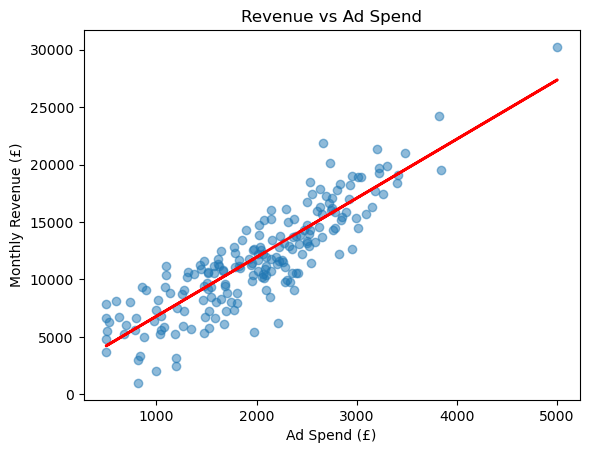

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Prepare data for linear regression
X = df[['ad_spend']]
y = df['monthly_sales']

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Create model
lr_model = LinearRegression()

# Step 2: Train model
lr_model.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = lr_model.predict(X_test)

# Step 4: Visualize results
plt.scatter(X_test, y_test, alpha=0.5)
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.title('Revenue vs Ad Spend')
plt.xlabel('Ad Spend (£)')
plt.ylabel('Monthly Revenue (£)')

In [49]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression Results:")
print(f"{'Coefficient':15s}: {lr_model.coef_[0]:.2f}") 
print(f"{'Intercept':15s}: £{lr_model.intercept_:8.2f}")
print(f"{'R² Score':15s}: {r2:.3f}")
print(f"{'RMSE':15s}: £ {rmse:.2f}")

Linear Regression Results:
Coefficient    : 5.14
Intercept      : £ 1656.90
R² Score       : 0.755
RMSE           : £ 2227.23


# Multiple Linear Regression

In [53]:
# Prepare data for linear regression
features = ['ad_spend', 'website_traffic', 'email_campaigns', 'social_media_reach']
X = df[features]
y = df['monthly_sales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Create model
lr_model = LinearRegression()

# Step 2: Train model
lr_model.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression Results:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: £ {rmse:.2f}")
print(f"Intercept: £ {lr_model.intercept_:.2f}")
print()
print("Feature Coefficients:")
for feature, coef in zip(features, lr_model.coef_):
    print(f"{feature:20s}: £{coef:8.2f}")

Linear Regression Results:
R² Score: 0.814
RMSE: £ 1941.28
Intercept: £ 92.69

Feature Coefficients:
ad_spend            : £    2.69
website_traffic     : £    0.81
email_campaigns     : £  131.30
social_media_reach  : £    0.01


# Logistic Regression

In [1]:
# Demonstrate Logistic Regression
print("="*50)
print("LOGISTIC REGRESSION DEMO")
print("="*50)

LOGISTIC REGRESSION DEMO


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Prepare data for logistic regression
X = df[['monthly_sales']]
y = df['high_value_customer']

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Create model
log_model = LogisticRegression(random_state=42)

# Step 2: Train model
log_model.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Step 4: Create realistic test cases based on actual patterns
test_customers = [
    # Low-value profile (below average in most metrics)
    [18000],
    # Medium-value profile (around average)
    [25000],
    # High-value profile (above average in most metrics)
    [35000],
    # Very high-value profile (top tier across all metrics)
    [45000]
]

print("\nPredictions on realistic customer profiles:")
for i, customer in enumerate(test_customers):
    pred = log_model.predict([customer])
    pred_proba = log_model.predict_proba([customer])
    profile = ['Low-Value', 'Medium-Value', 'High-Value', 'Very High-Value'][i]
    print(f"{profile} Profile: {'High-Value' if pred[0] == 1 else 'Regular'} "
          f"(Probability: {pred_proba[0][1]:.3f})")
    print(f"  [Sales: £{customer[0]}]")


Predictions on realistic customer profiles:
Low-Value Profile: Regular (Probability: 0.165)
  [Sales: £18000]
Medium-Value Profile: Regular (Probability: 0.416)
  [Sales: £25000]
High-Value Profile: High-Value (Probability: 0.816)
  [Sales: £35000]
Very High-Value Profile: High-Value (Probability: 0.965)
  [Sales: £45000]


C:\Users\riyab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\riyab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\riyab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\riyab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\riyab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\riyab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X d

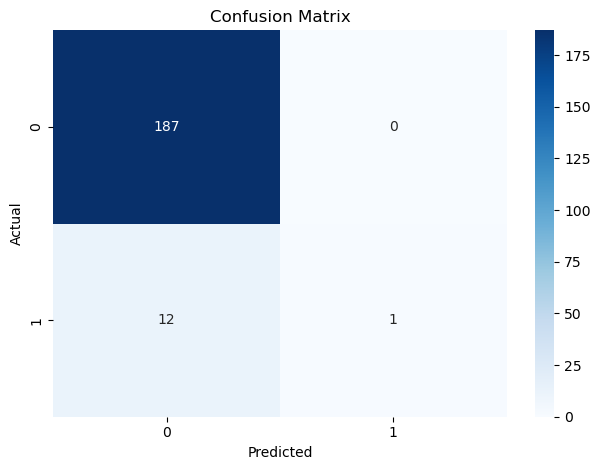

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [33]:
# Step 5: Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.940

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       187
           1       1.00      0.08      0.14        13

    accuracy                           0.94       200
   macro avg       0.97      0.54      0.56       200
weighted avg       0.94      0.94      0.92       200



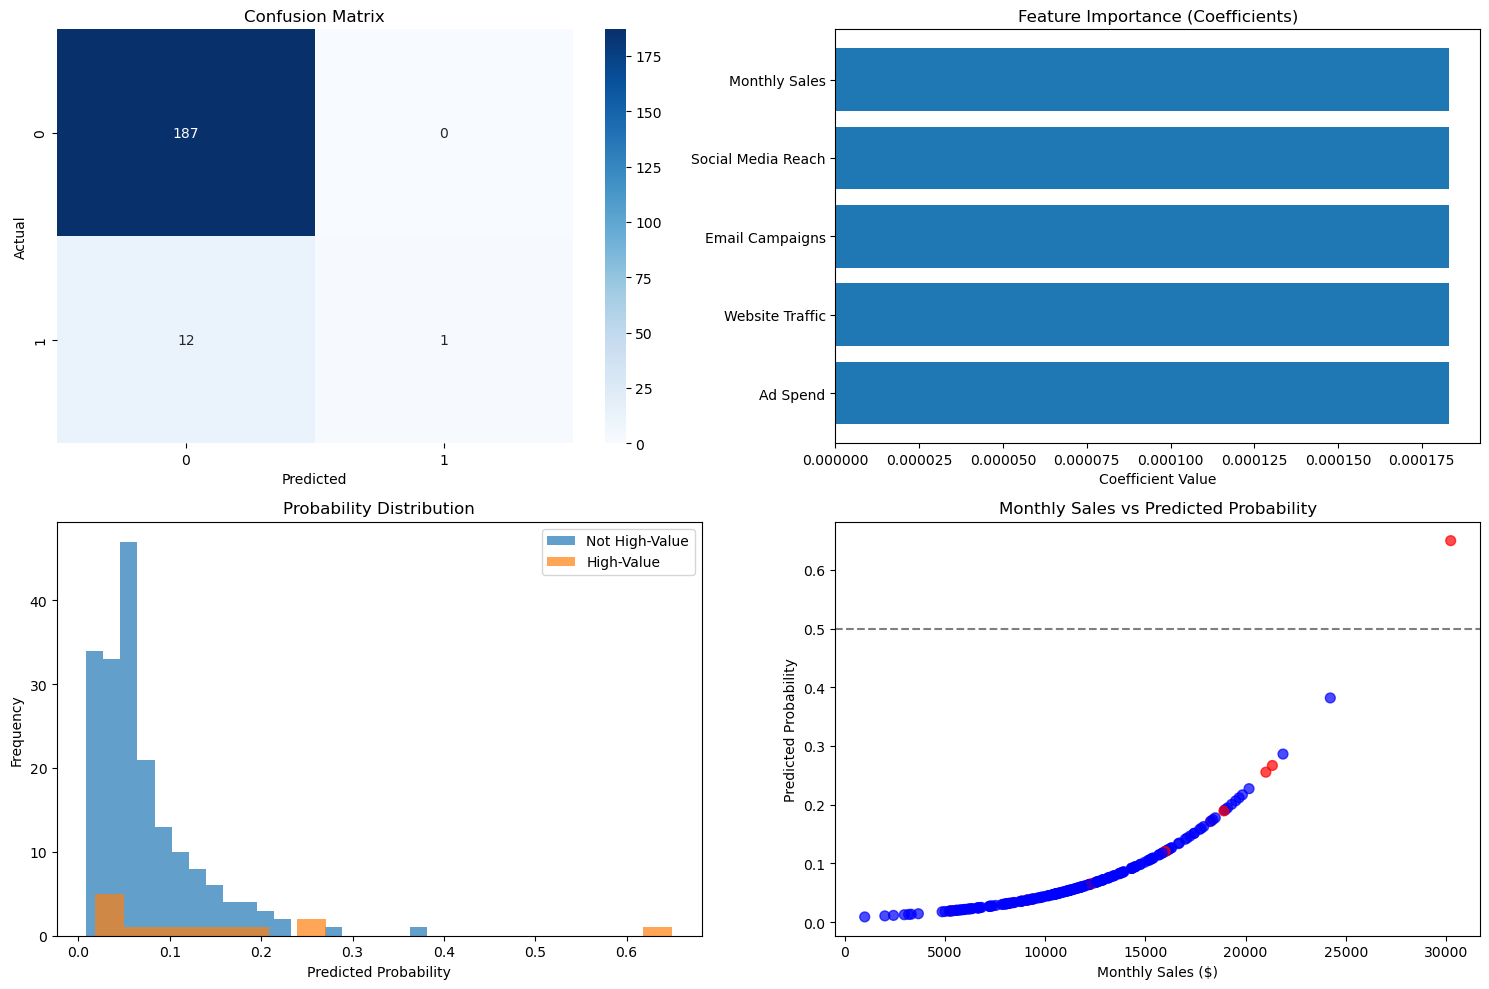

In [36]:

# Step 5: Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# Feature Importance
feature_names = ['Ad Spend', 'Website Traffic', 'Email Campaigns', 'Social Media Reach', 'Monthly Sales']
coefficients = log_model.coef_[0]
axes[0,1].barh(feature_names, coefficients)
axes[0,1].set_title('Feature Importance (Coefficients)')
axes[0,1].set_xlabel('Coefficient Value')

# Probability Distribution
axes[1,0].hist(y_pred_proba[y_test==0], alpha=0.7, label='Not High-Value', bins=20)
axes[1,0].hist(y_pred_proba[y_test==1], alpha=0.7, label='High-Value', bins=20)
axes[1,0].set_title('Probability Distribution')
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Monthly Sales vs Probability
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
colors = ['red' if val == 1 else 'blue' for val in y_test_reset]
axes[1,1].scatter(X_test_reset['monthly_sales'], y_pred_proba, c=colors, alpha=0.7, s=50)
axes[1,1].set_title('Monthly Sales vs Predicted Probability')
axes[1,1].set_xlabel('Monthly Sales ($)')
axes[1,1].set_ylabel('Predicted Probability')
axes[1,1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## ROC Curve

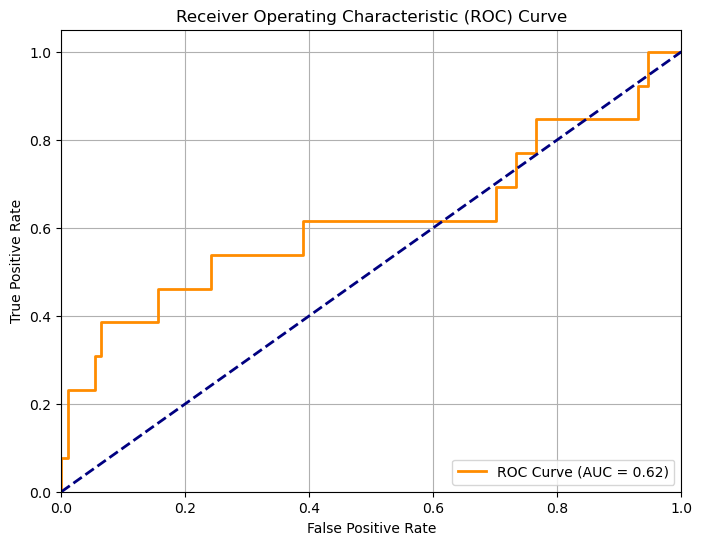

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you already have:
# y_test = true labels
# y_prob = predicted probabilities from model (not class labels)

# 1. Get the False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 2. Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# 3. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()